In [187]:
import pandas as pd
import seaborn as sns
import numpy as np
data = pd.read_excel("Realized Schedule 20210101-20220208.xlsx")
sns.set_theme()
data

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301
...,...,...,...,...,...,...,...,...,...
36765,2022-02-08 18:30:00,VW,986,YYZ,320,J,CA,180,0.522222
36766,2022-02-08 19:30:00,LJ,579,YQU,319,J,CA,156,0.532051
36767,2022-02-08 19:40:00,LJ,506,YUL,319,J,CA,156,0.602564
36768,2022-02-08 19:05:00,CL,2708,DAN,73H,J,US,189,0.417989


## Encode dates

In [188]:
# holidays 
from pandas.tseries.holiday import *
from pandas.tseries.offsets import CustomBusinessDay

class GothamBusinessCalendar(AbstractHolidayCalendar):
   rules = [
     Holiday('New Year', month=1, day=1, observance=sunday_to_monday),
     Holiday('Groundhog Day', month=1, day=6, observance=sunday_to_monday),
     Holiday('St. Patricks Day', month=3, day=17, observance=sunday_to_monday),
     Holiday('April Fools Day', month=4, day=1),
     Holiday('Good Friday', month=1, day=1, offset=[Easter(), Day(-2)]),
     Holiday('Labor Day', month=5, day=1, observance=sunday_to_monday),
     Holiday('Canada Day', month=7, day=1, observance=sunday_to_monday),
     Holiday('July 4th', month=7, day=4, observance=nearest_workday),
     Holiday('All Saints Day', month=11, day=1, observance=sunday_to_monday),
     Holiday('Christmas', month=12, day=25, observance=nearest_workday)
   ]

Gotham_BD = CustomBusinessDay(calendar=GothamBusinessCalendar())

# add time stuff
data["Hour"] = data.ScheduleTime.dt.hour
data["Date"] = data.ScheduleTime.dt.date
data["Holiday"] = data.Date.isin(pd.date_range(min(data.Date), end=max(data.Date), freq=Gotham_BD)) == False
data["Weekday"] = data.ScheduleTime.dt.day_name()

data["QuarterEnd"] = data.ScheduleTime.dt.to_period("Q").dt.end_time
data["MonthEnd"] = data.ScheduleTime.dt.to_period("M").dt.end_time
# data["BusinessMonthEnd"] = data.ScheduleTime.dt.to_period("BM").dt.end_time
data["TimeToQuarterEnd"] = (data["QuarterEnd"] - data["ScheduleTime"]).dt.days
data["TimeToMonthEnd"] = (data["MonthEnd"] - data["ScheduleTime"]).dt.days

## Encode time of day as cos and sin
_ = data.ScheduleTime
_ = ((_ - _.dt.normalize()) / pd.Timedelta('1 second')).astype(int)
_/=3600*24*2*np.pi
data["TimeCos"] = t2.apply(np.cos)
data["TimeSin"] = t2.apply(np.sin)

# data["TimeToBusinessMonthEnd"] = (data["BusinessMonthEnd"] - data["ScheduleTime"]).dt.days

/home/hinge/.virtualenvs/ai/lib/python3.10/site-packages/pandas/core/algorithms.py:521: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return f(comps, values)


## Flight numbers are not unique across airlines and destinations
They should be unique across airlines and possibly destinations. 

In [189]:
d_ = data[["Airline","Destination","FlightNumber"]]
d_.groupby("FlightNumber").agg({"Airline": "nunique","Destination":"nunique"})

,Airline,Destination
FlightNumber,,
500,2,2
501,1,1
504,1,1
505,1,1
506,1,1
...,...,...
3738,1,1
3745,1,1
3746,1,1


In [190]:
data[data.FlightNumber == 500]

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor,Hour,Date,Holiday,Weekday,QuarterEnd,MonthEnd,TimeToQuarterEnd,TimeToMonthEnd,TimeCos,TimeSin
15104,2021-10-10 09:55:00,FK,500,EST,318,C,US,107,0.065421,9,2021-10-10,True,Sunday,2021-12-31 23:59:59.999999999,2021-10-31 23:59:59.999999999,82,21,0.998818,0.048612
15824,2021-10-16 13:35:00,CN,500,YXY,M83,J,CA,172,0.837209,13,2021-10-16,True,Saturday,2021-12-31 23:59:59.999999999,2021-10-31 23:59:59.999999999,76,15,0.989932,0.141547


In [191]:
data["FlightNumber2"] = data.Airline+data.FlightNumber.astype("str")

In [192]:
d_ = data[["Airline","Destination","FlightNumber2"]]
query = d_.groupby("FlightNumber2").agg({"Airline": "nunique","Destination":"nunique"})
query[query.Airline!=1]

,Airline,Destination
FlightNumber2,,


In [195]:
query[query.Destination!=1]

,Airline,Destination
FlightNumber2,,
AY654,1,2
AY986,1,2
CL1391,1,2
CL2701,1,2
CL2708,1,2
...,...,...
ZD768,1,3
ZD771,1,2
ZD785,1,2


In [196]:
data[data.FlightNumber2 == "ZD768"]

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor,Hour,Date,Holiday,Weekday,QuarterEnd,MonthEnd,TimeToQuarterEnd,TimeToMonthEnd,TimeCos,TimeSin,FlightNumber2
26343,2021-07-01 07:55:00,ZD,768,CBF,73H,J,US,189,0.772487,7,2021-07-01,True,Thursday,2021-09-30 23:59:59.999999999,2021-07-31 23:59:59.999999999,91,30,0.998051,0.062406,ZD768
26408,2021-07-04 07:05:00,ZD,768,CBF,73H,J,US,189,0.582011,7,2021-07-04,True,Sunday,2021-09-30 23:59:59.999999999,2021-07-31 23:59:59.999999999,88,27,0.990848,0.134979,ZD768
26527,2021-07-08 07:40:00,ZD,768,CBF,73H,J,US,189,0.507937,7,2021-07-08,True,Thursday,2021-09-30 23:59:59.999999999,2021-07-31 23:59:59.999999999,84,23,0.993080,0.117437,ZD768
26603,2021-07-11 06:25:00,ZD,768,CBF,73H,J,US,189,0.518519,6,2021-07-11,True,Sunday,2021-09-30 23:59:59.999999999,2021-07-31 23:59:59.999999999,81,20,0.998504,0.054682,ZD768
26673,2021-07-13 07:25:00,ZD,768,CBF,73H,J,US,189,0.380952,7,2021-07-13,True,Tuesday,2021-09-30 23:59:59.999999999,2021-07-31 23:59:59.999999999,79,18,0.995433,0.095458,ZD768
27035,2021-07-25 06:30:00,ZD,768,CBF,73H,J,US,189,0.211640,6,2021-07-25,True,Sunday,2021-09-30 23:59:59.999999999,2021-07-31 23:59:59.999999999,67,6,0.998317,0.057993,ZD768
27173,2021-07-29 08:10:00,ZD,768,CBF,73H,J,US,189,0.169312,8,2021-07-29,True,Thursday,2021-09-30 23:59:59.999999999,2021-07-31 23:59:59.999999999,63,2,0.998791,0.049163,ZD768
27640,2021-08-12 07:20:00,ZD,768,CBF,73H,J,US,189,0.206349,7,2021-08-12,True,Thursday,2021-09-30 23:59:59.999999999,2021-08-31 23:59:59.999999999,49,19,0.997341,0.072881,ZD768
27735,2021-08-15 07:05:00,ZD,768,CBF,73H,J,US,189,0.100529,7,2021-08-15,True,Sunday,2021-09-30 23:59:59.999999999,2021-08-31 23:59:59.999999999,46,16,0.990923,0.134431,ZD768
27977,2021-08-22 06:00:00,ZD,768,CBF,73H,J,US,189,0.169312,6,2021-08-22,True,Sunday,2021-09-30 23:59:59.999999999,2021-08-31 23:59:59.999999999,39,9,0.992752,0.120180,ZD768


Text(0.5, 1.0, 'Flights to each country')

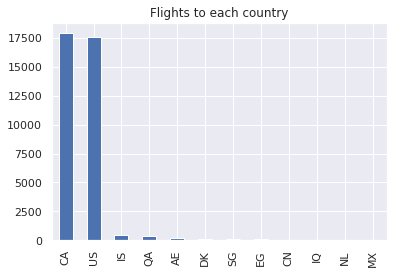

In [186]:
ax = data.Sector.value_counts().plot.bar()
ax.set_title("Flights to each country")

In [71]:
_d = d[["AircraftType","SeatCapacity"]]
_d.groupby("AircraftType").agg({"SeatCapacity":"nunique"})

,SeatCapacity
AircraftType,
221,1
223,1
295,1
318,2
319,9
320,11
321,18
332,7
333,5


In [77]:
d[d.AircraftType==321].describe()

,FlightNumber,SeatCapacity,LoadFactor,Passengers
count,265.000000,265.000000,265.000000,265.000000
mean,990.188679,201.547170,0.734997,148.456604
std,505.774438,12.829839,0.231631,48.167312
min,547.000000,141.000000,0.000000,0.000000
25%,750.000000,200.000000,0.597156,118.000000
50%,872.000000,200.000000,0.780000,156.000000
75%,1094.000000,211.000000,0.913242,187.000000
max,3580.000000,220.000000,1.475177,222.000000


/home/hinge/.virtualenvs/ai/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


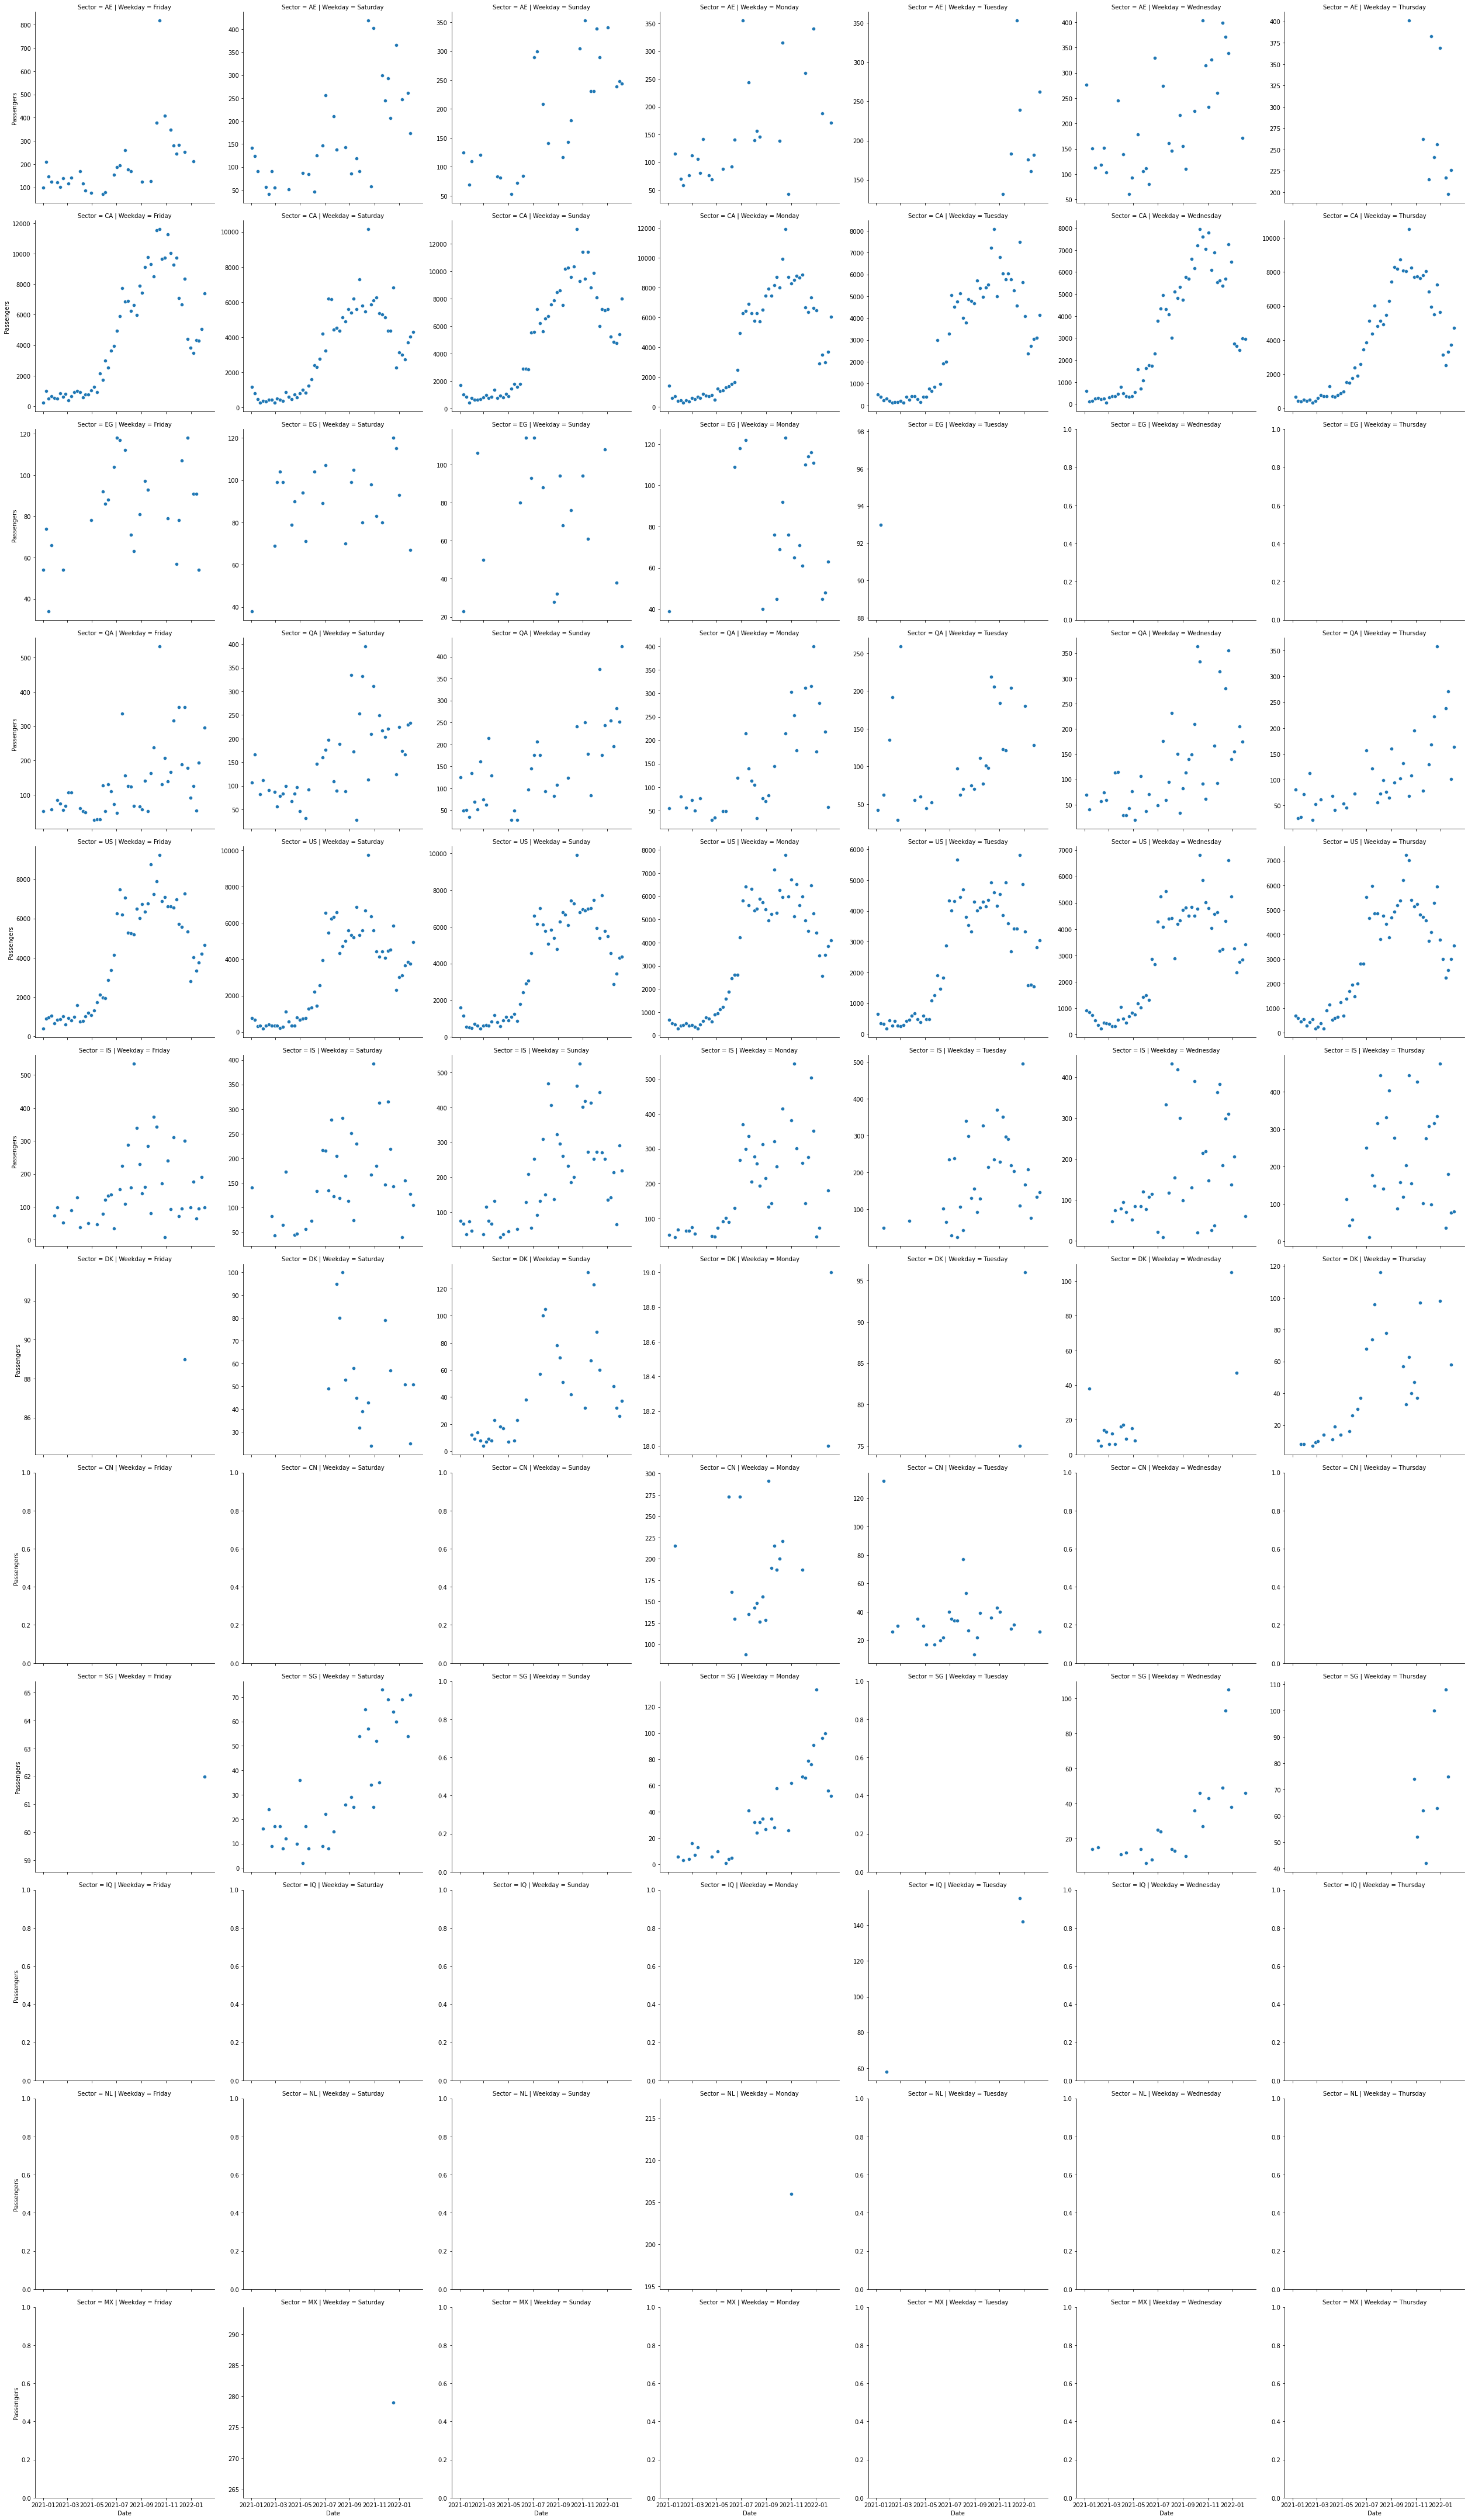

In [105]:
data["Passengers"] = data.SeatCapacity*data.LoadFactor
d2 = data.groupby(["Date","Sector","Weekday"]).sum().reset_index()

#d3 = d2[d2.Sector.isin(["US","CA"])]
#d4 = d2[~d2.Sector.isin(["US","CA"])]

import seaborn as sns
sns.relplot("Date","Passengers",data=d2,row="Sector",kind="scatter",col="Weekday",facet_kws={'sharey': False, 'sharex': True})

/home/hinge/.virtualenvs/ai/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


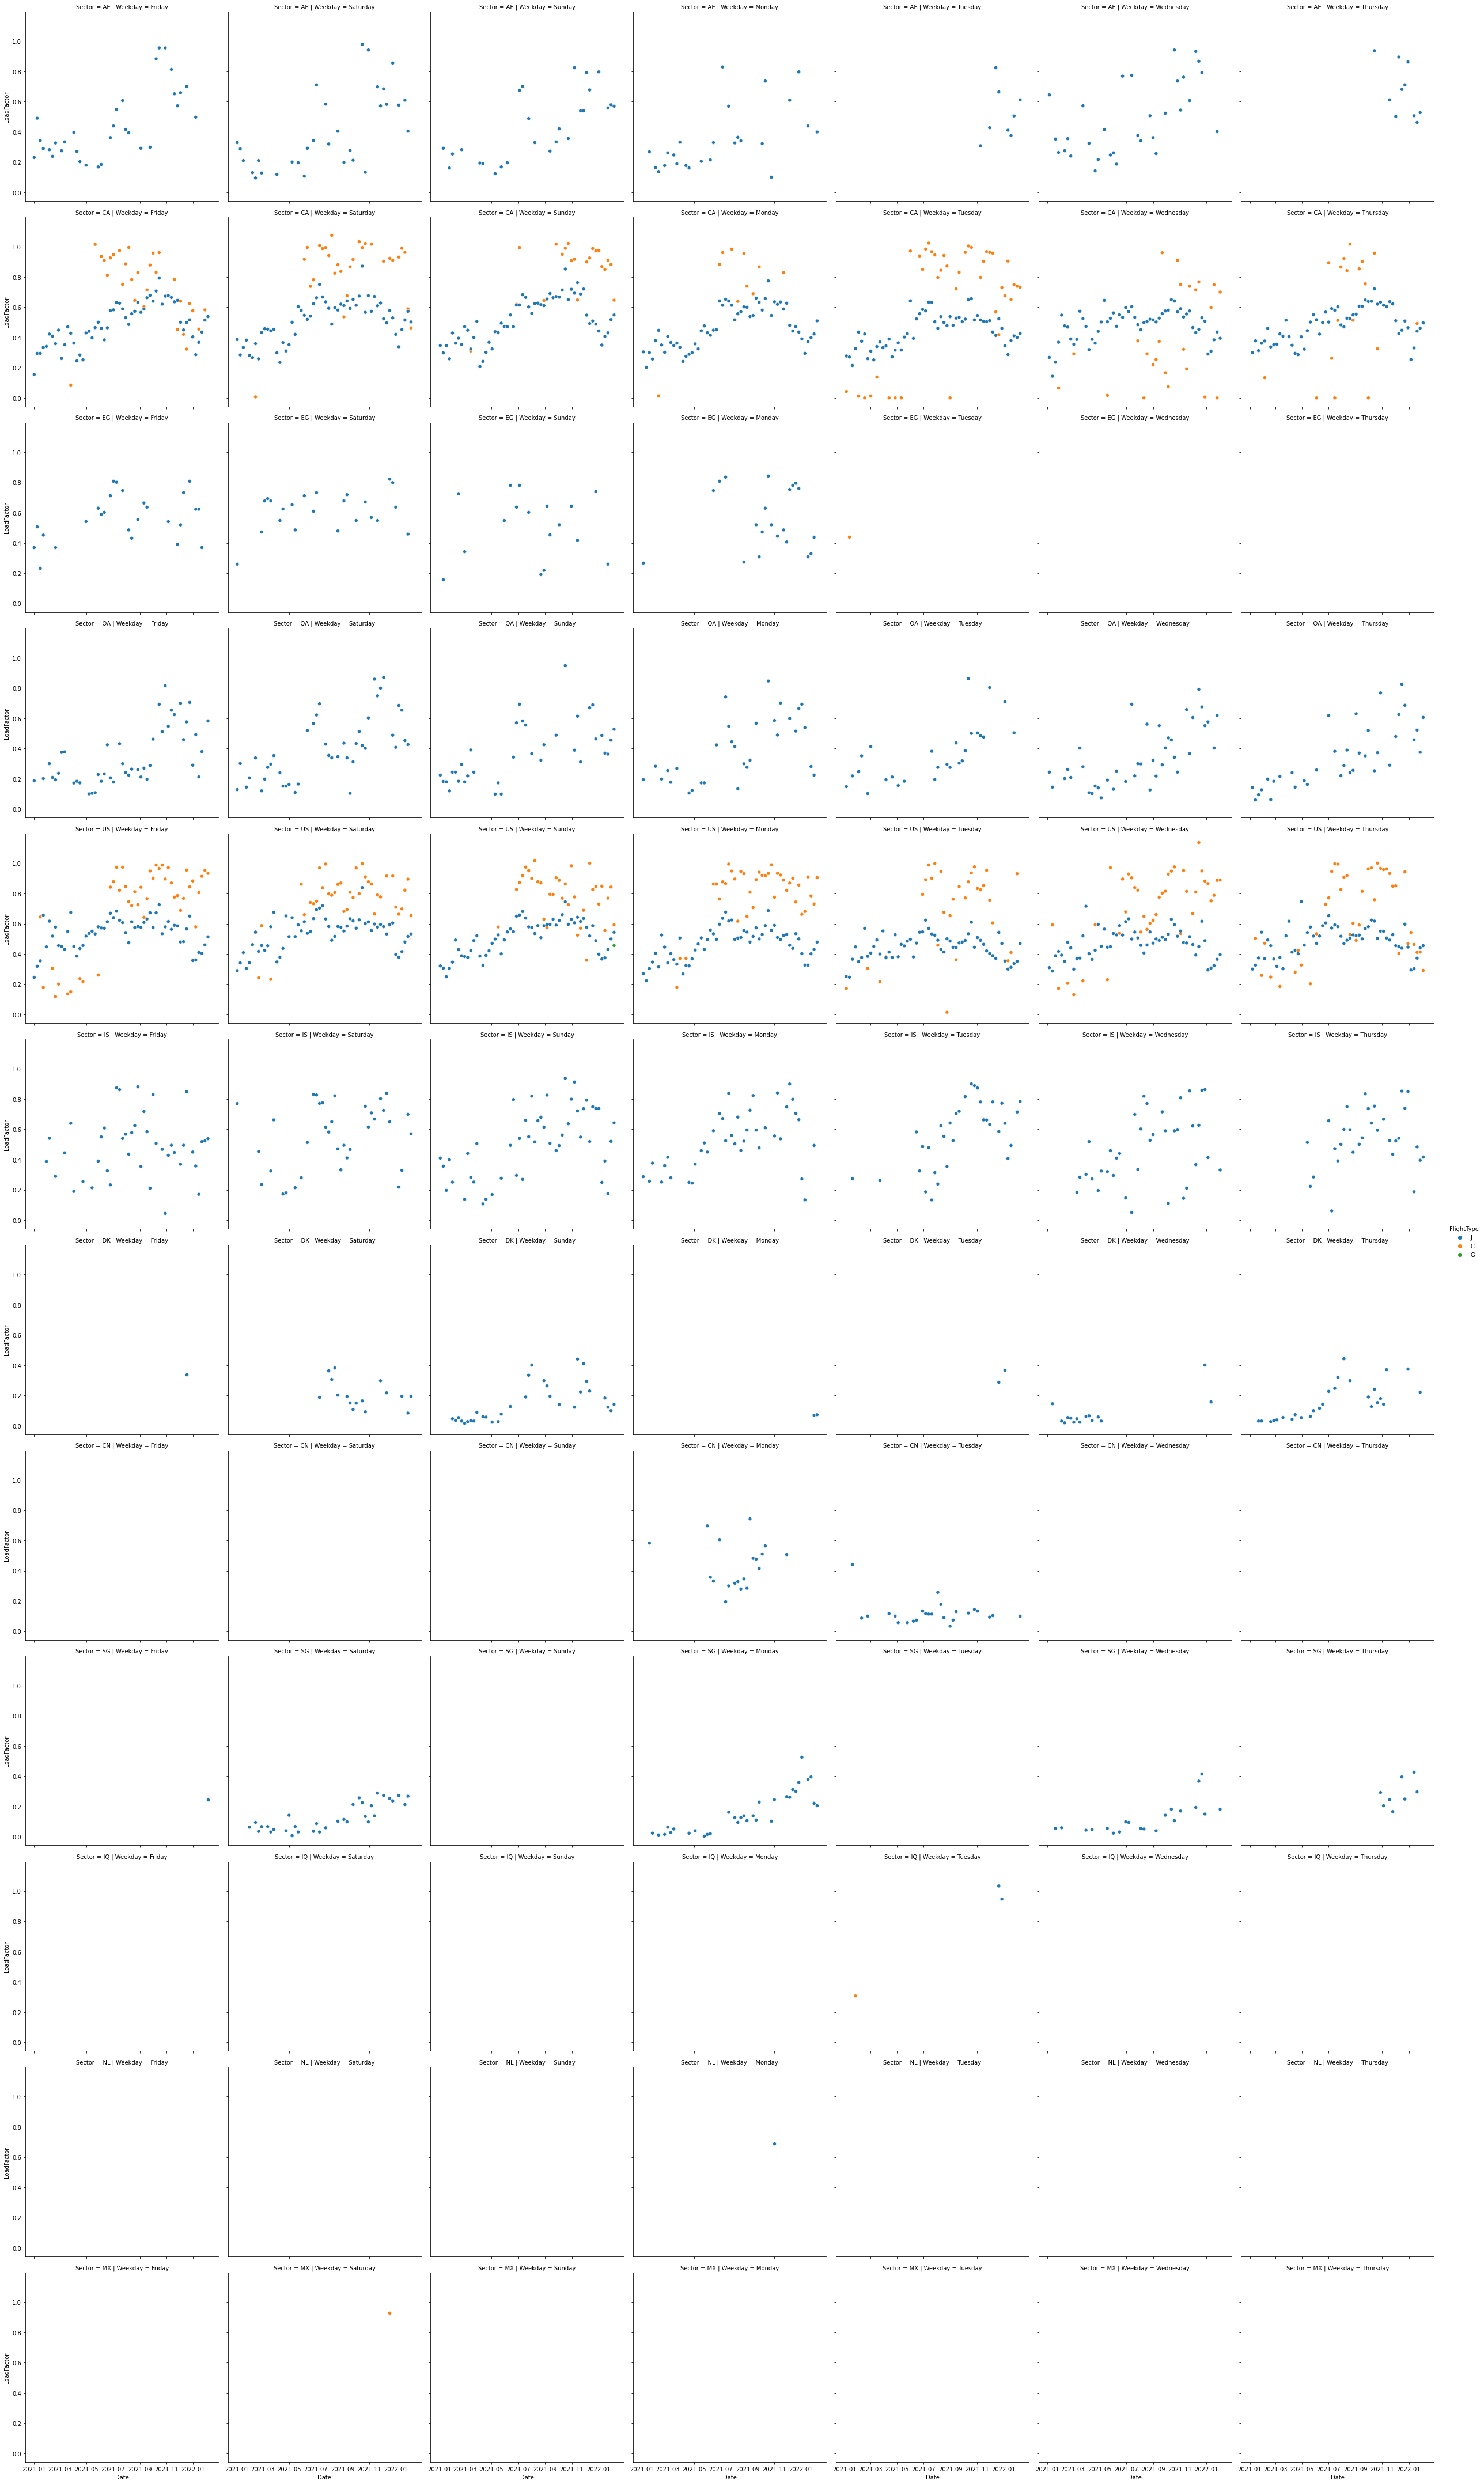

In [106]:
d_ = data.groupby(["Date","Sector","Weekday","FlightType"]).mean().reset_index()
sns.relplot("Date","LoadFactor",data=d_,row="Sector",kind="scatter",col="Weekday",hue="FlightType")

<AxesSubplot:>

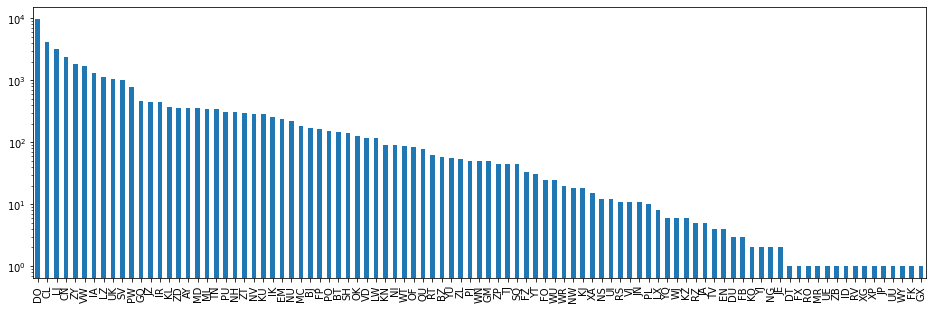

In [97]:
from matplotlib import pyplot as plt
counts = d.Airline.value_counts()
plt.figure(figsize=(16,5))
counts.plot.bar(logy=True)

In [118]:
fig

NameError: name 'fig' is not defined

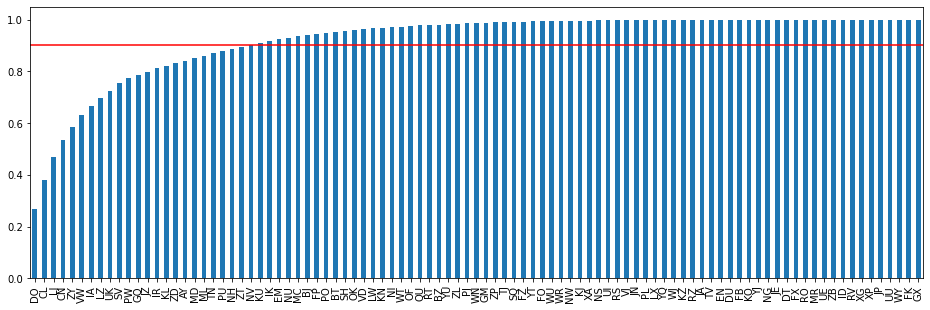

In [129]:
plt.figure(figsize=(16,5))
ax = (counts/counts.sum()).cumsum().plot.bar()
plt.plot(ax.get_xlim(),[0.9,0.9],'r')


In [100]:
valid_airlines = counts.index[counts>1000]
valid_airlines

Index(['DO', 'CL', 'LJ', 'CN', 'ZY', 'VW', 'IA', 'LZ', 'UK', 'SV'], dtype='object')

<AxesSubplot:xlabel='SeatCapacity', ylabel='LoadFactor'>

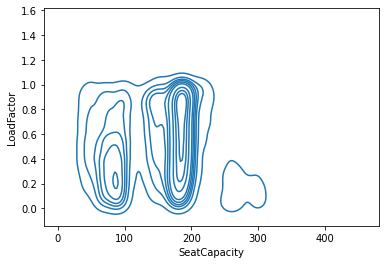

In [181]:
sns.kdeplot(x="SeatCapacity",y="LoadFactor",data=data)

/home/hinge/.virtualenvs/ai/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


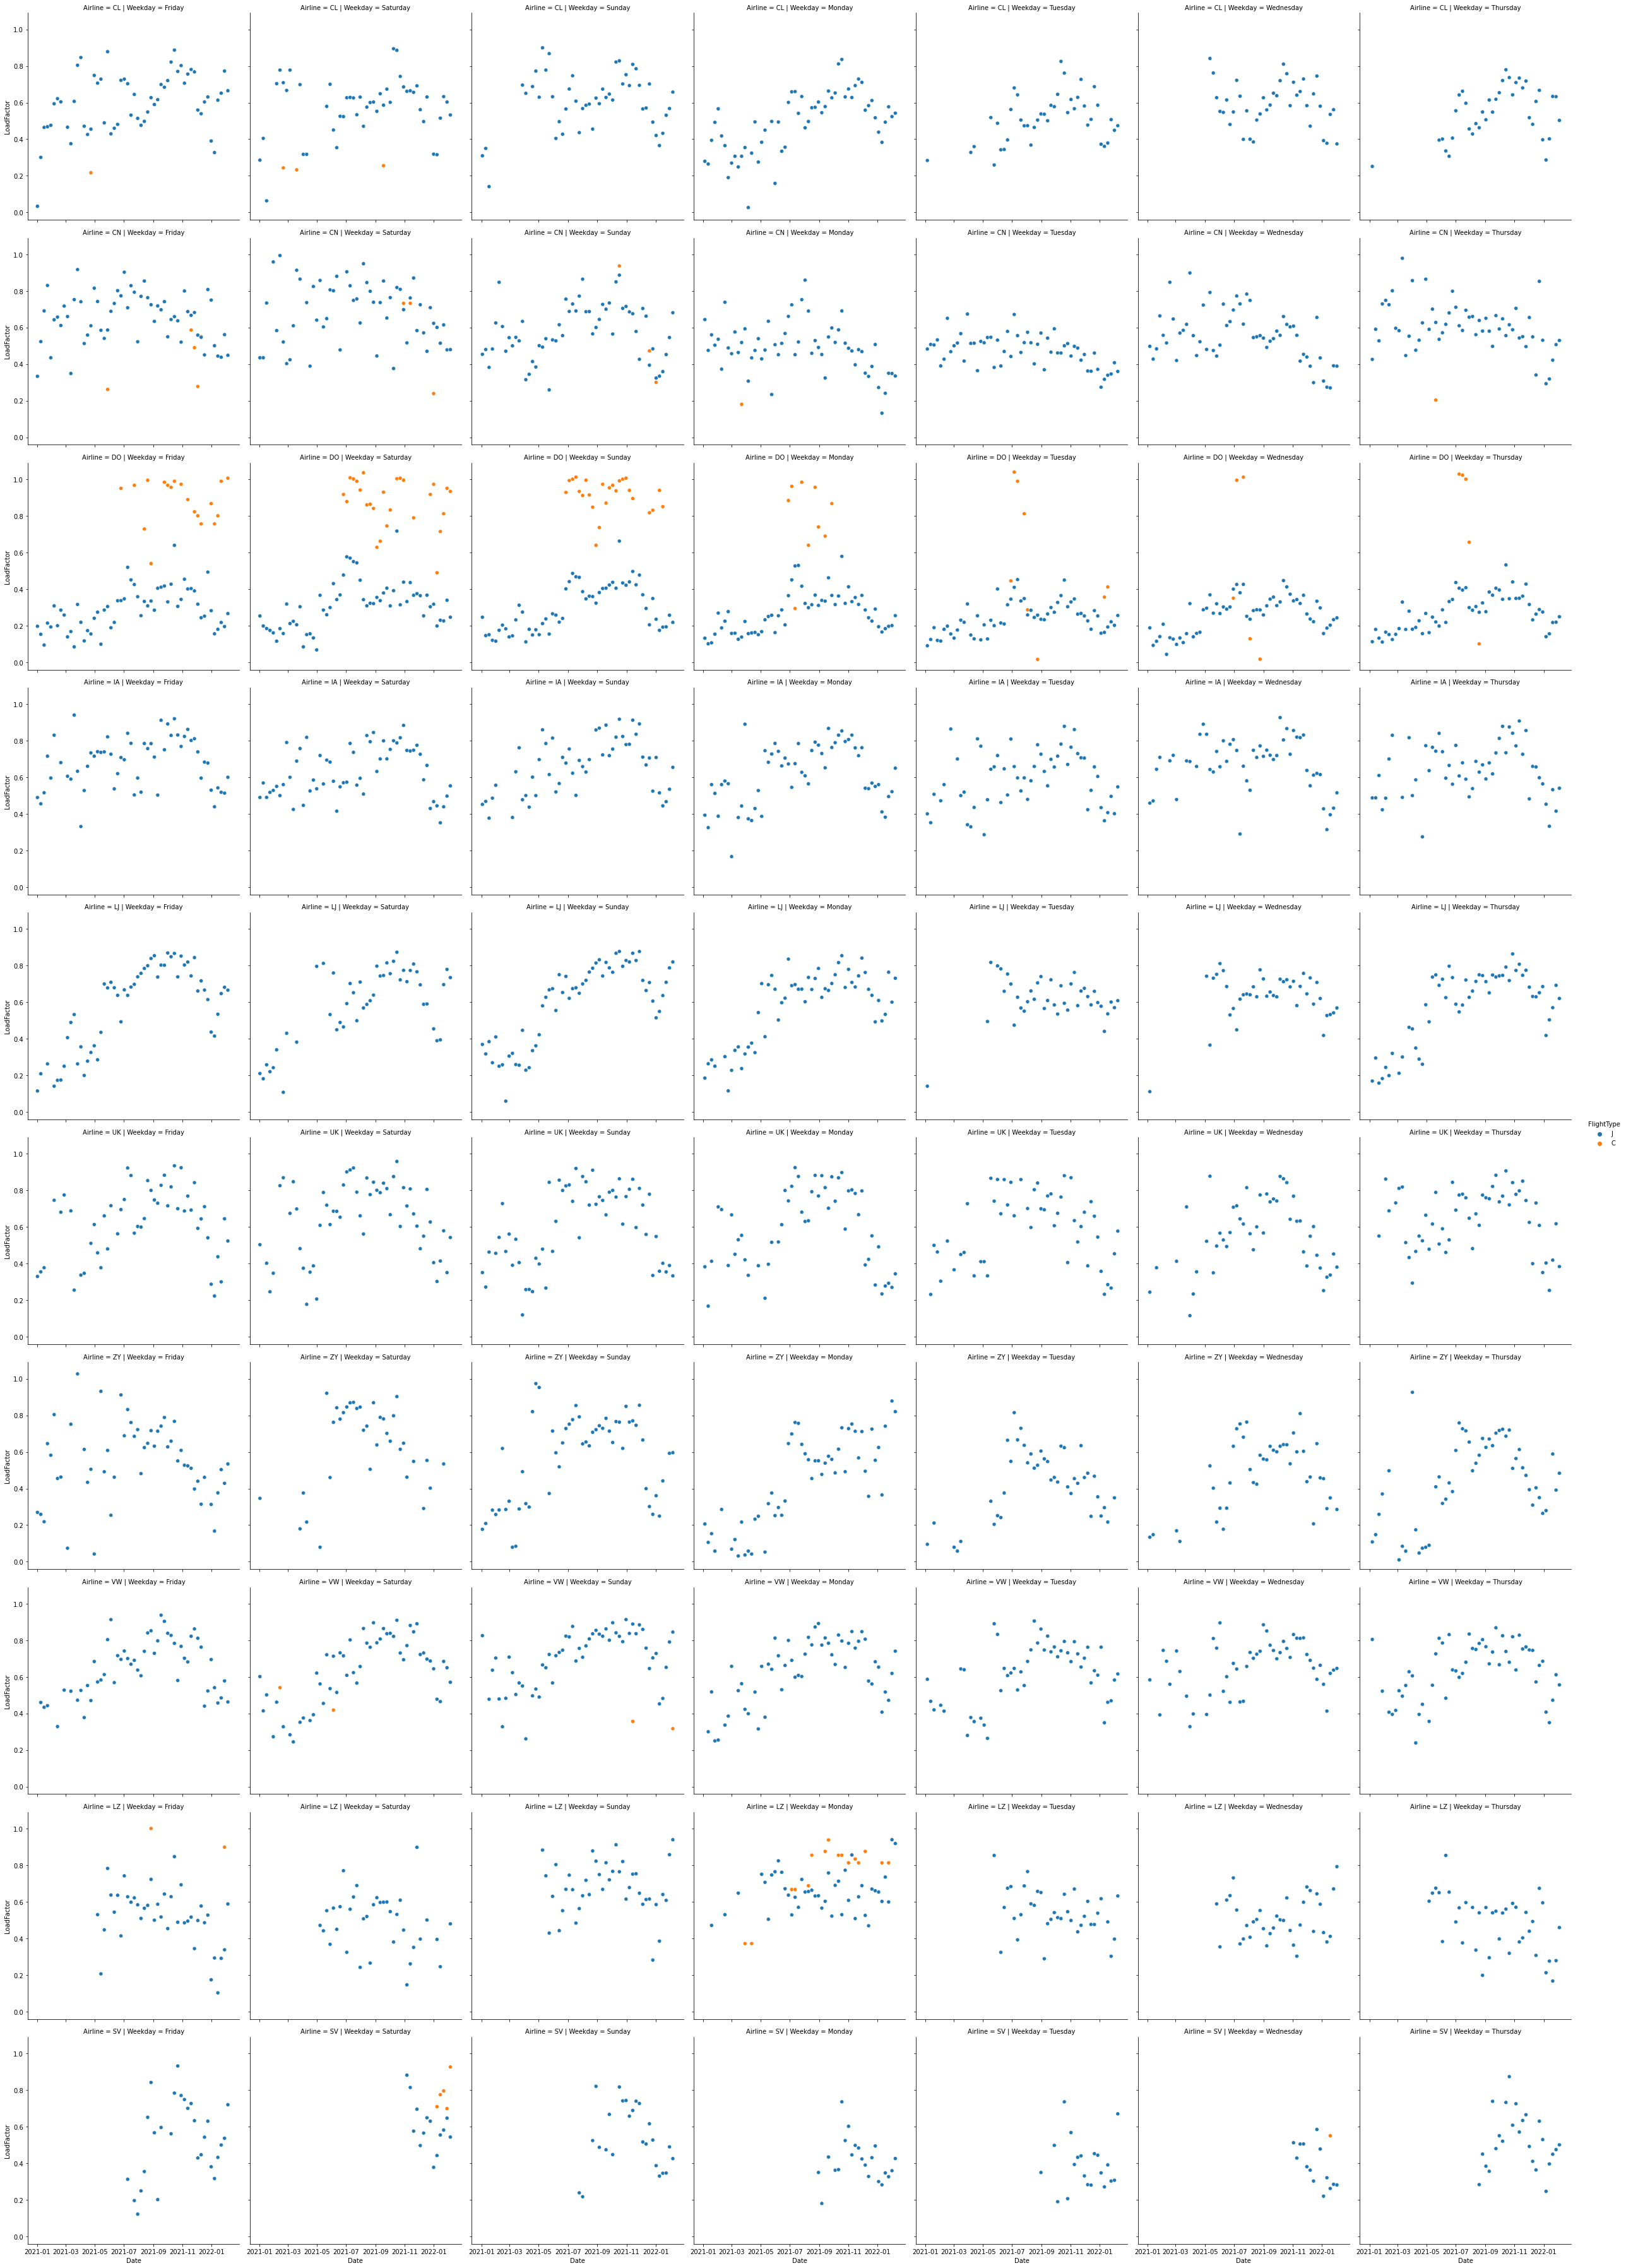

In [103]:
valid_airlines = counts.index[counts>1000]


d_ = data[data.Airline.isin(valid_airlines)].groupby(["Date","Airline","Weekday","FlightType"]).mean().reset_index()

sns.relplot("Date","LoadFactor",data=d_,row="Airline",kind="scatter",col="Weekday",hue="FlightType")

In [132]:
data.columns

Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor',
       'Hour', 'Date', 'Holiday', 'Weekday', 'QuarterEnd', 'MonthEnd',
       'TimeToQuarterEnd', 'TimeToMonthEnd', 'Passengers'],
      dtype='object')

In [182]:
data.FlightNumber2

AttributeError: 'DataFrame' object has no attribute 'FlightNumber2'